In [83]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.layers import GRU, Bidirectional, Dropout, Input, TimeDistributed, BatchNormalization, Dense, Conv1D, Activation, UpSampling1D
from keras.models import Model
from keras.optimizers import Adam
from livelossplot import PlotLossesKeras
import IPython.display as ipd
from tqdm import tqdm_notebook as tqdm

In [2]:
data = pd.read_pickle("../Data/Guitar/guitar-data-indnotes-500.pkl")
data = data.sample(frac=1)

In [3]:
%run ../Utilities/Chord_data_generator.ipynb

In [4]:
data.shape

(5375, 3)

In [5]:
train_gen = Chordgen(data[:4000], 6, 6, 64, 100)
val_gen = Chordgen(data[4000:], 6, 6, 64, 100)

In [7]:
_ = train_gen.__getitem__(0)

In [8]:
_[0][0].shape, _[1][0].shape

((40, 100), (6, 26))

In [9]:
chunks = 40
freqs = 100
strings = 6

In [13]:
def build_model(input_shape):
    X_input = Input(shape=input_shape)
    X = Conv1D(128, kernel_size=3, strides=1)(X_input)
    X = BatchNormalization()(X)
    X = Activation("relu")(X)
    X = Conv1D(512, kernel_size=6, strides=6)(X)
    X = BatchNormalization()(X)
    X = Activation("relu")(X)
    X = Bidirectional(GRU(units = 256, return_sequences = True, recurrent_dropout=0))(X)
    X = BatchNormalization()(X)
    X_output = TimeDistributed(Dense(26, activation = "softmax"))(X)
    
    return Model(inputs=X_input, outputs=X_output)

In [14]:
model = build_model((chunks,freqs))

In [15]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 40, 100)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 38, 128)           38528     
_________________________________________________________________
batch_normalization_4 (Batch (None, 38, 128)           512       
_________________________________________________________________
activation_3 (Activation)    (None, 38, 128)           0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 6, 512)            393728    
_________________________________________________________________
batch_normalization_5 (Batch (None, 6, 512)            2048      
_________________________________________________________________
activation_4 (Activation)    (None, 6, 512)            0         
__________

In [16]:
model.compile(Adam(0.001), loss="categorical_crossentropy", metrics=["accuracy"])

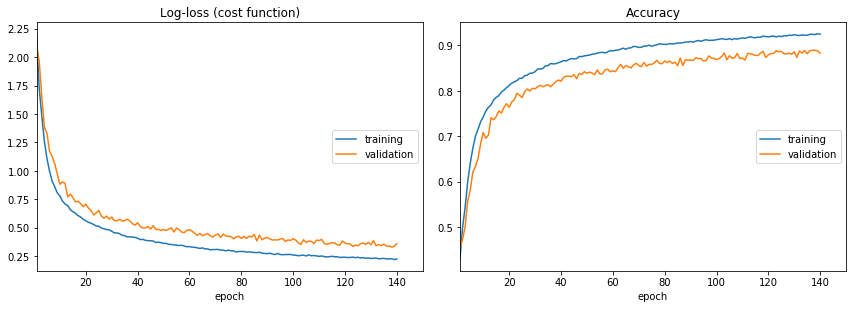

Log-loss (cost function):
training   (min:    0.220, max:    2.205, cur:    0.223)
validation (min:    0.329, max:    2.097, cur:    0.359)

Accuracy:
training   (min:    0.429, max:    0.926, cur:    0.925)
validation (min:    0.454, max:    0.889, cur:    0.883)
Epoch 141/150
14/63 [=====>........................] - ETA: 2s - loss: 0.2510 - acc: 0.918 - ETA: 3s - loss: 0.2460 - acc: 0.919 - ETA: 3s - loss: 0.2360 - acc: 0.920 - ETA: 3s - loss: 0.2325 - acc: 0.921 - ETA: 3s - loss: 0.2291 - acc: 0.923 - ETA: 3s - loss: 0.2251 - acc: 0.924 - ETA: 3s - loss: 0.2255 - acc: 0.924 - ETA: 3s - loss: 0.2224 - acc: 0.925 - ETA: 3s - loss: 0.2241 - acc: 0.925 - ETA: 27s - loss: 0.2218 - acc: 0.92 - ETA: 58s - loss: 0.2227 - acc: 0.92 - ETA: 1:24 - loss: 0.2219 - acc: 0.925 - ETA: 1:44 - loss: 0.2238 - acc: 0.924 - ETA: 2:03 - loss: 0.2246 - acc: 0.9241

KeyboardInterrupt: 

In [18]:
history = model.fit_generator(train_gen, epochs=150, validation_data=val_gen, 
                              steps_per_epoch=np.ceil(4000/train_gen.batch_size),
                              callbacks=[PlotLossesKeras()])

## Transfer learning with real chords

In [185]:
data = pd.read_pickle("../Data/Guitar/real_chords.pkl")

In [188]:
# ind = pd.read_pickle("../Data/Guitar/guitar-data-indnotes-500.pkl").sample(60)
# data = pd.concat([data[["xf", "Notes"]], ind[["xf", "Notes"]]])

In [190]:
data = data.sample(frac=1)

In [191]:
train_data = data[:int(data.shape[0]*0.8)]
val_data = data[int(data.shape[0]*0.8):]

In [192]:
chunks, freqs = data["xf"].sample().values[0].shape
strings = 6

In [193]:
X_train = np.array([[[]]])
y_train = np.array([[[]]])
for i in tqdm(range(train_data.shape[0])):
    x = train_data["xf"].values[i].reshape((1, chunks, freqs))
    X_train = np.append(X_train, x)
    y = train_data["Notes"].values[i].reshape((1, strings, 1))
    y_train = np.append(y_train, y)
    
X_val = np.array([[[]]])
y_val = np.array([[[]]])
for i in tqdm(range(val_data.shape[0])):
    x = val_data["xf"].values[i].reshape((1, chunks, freqs))
    X_val = np.append(X_val, x)
    y = val_data["Notes"].values[i].reshape((1, strings, 1))
    y_val = np.append(y_val, y)

In [194]:
X_train = X_train.reshape(train_data.shape[0], chunks, freqs)
X_val = X_val.reshape(val_data.shape[0], chunks, freqs)
y_train = y_train.reshape(train_data.shape[0], 6, 1)
y_val = y_val.reshape(val_data.shape[0], 6, 1)

In [195]:
from keras.utils import to_categorical
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)

In [196]:
X_train.shape, y_train.shape

((96, 40, 100), (96, 6, 26))

In [197]:
def build_model(input_shape):
    X_input = Input(shape=input_shape)
    X = Conv1D(128, kernel_size=3, strides=1, trainable=False)(X_input)
    X = BatchNormalization()(X)
    X = Activation("relu")(X)
    X = Conv1D(512, kernel_size=6, strides=6, trainable=False)(X)
    X = BatchNormalization()(X)
    X = Activation("relu")(X)
    X = Bidirectional(GRU(units = 256, return_sequences = True, recurrent_dropout=0.5))(X)
    X = BatchNormalization()(X)
    X_output = TimeDistributed(Dense(26, activation = "softmax"))(X)
    
    return Model(inputs=X_input, outputs=X_output)

In [198]:
model = build_model((chunks,freqs))

In [199]:
model.compile(Adam(0.001), loss="categorical_crossentropy", metrics=["accuracy"])

In [200]:
model.load_weights("Checkpoints/chord_model_v1.hdf5")

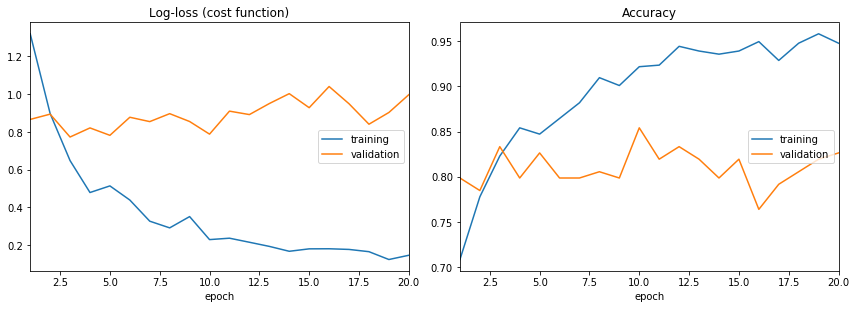

Log-loss (cost function):
training   (min:    0.124, max:    1.320, cur:    0.147)
validation (min:    0.773, max:    1.040, cur:    0.997)

Accuracy:
training   (min:    0.708, max:    0.958, cur:    0.948)
validation (min:    0.764, max:    0.854, cur:    0.826)


In [201]:
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_val, y_val), callbacks=[PlotLossesKeras()],
                    batch_size=4)

In [202]:
preds = model.predict(X_val)

In [205]:
np.argmax(preds[0], axis=1)

array([25, 25, 25, 25, 25, 25], dtype=int64)

In [206]:
np.argmax(y_val[0], axis=1)

array([25, 25, 25, 10, 12, 25], dtype=int64)

### Generator with augmentation

In [110]:
%run ../Utilities/Data_generator.ipynb

In [111]:
datagen = Datagen(X_train, y_train, 4, p_white_noise=0.75, white_noise_strength=0.2, p_cutout=0.5, n_cutout=1000)
a = datagen.__getitem__(0)
a[0].shape

(4, 40, 100)

In [112]:
model.load_weights("Checkpoints/chord_model_v1.hdf5")

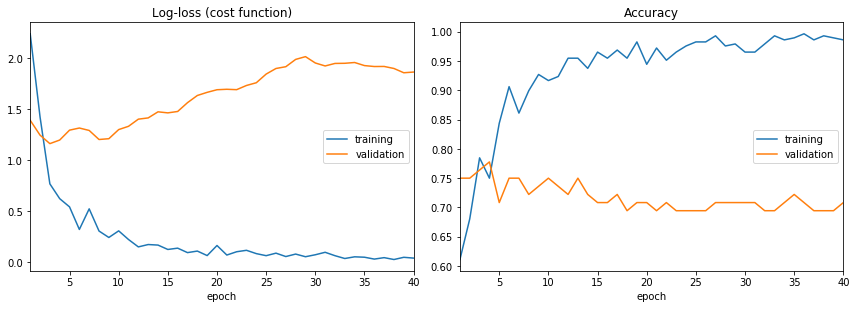

Log-loss (cost function):
training   (min:    0.026, max:    2.238, cur:    0.040)
validation (min:    1.161, max:    2.014, cur:    1.863)

Accuracy:
training   (min:    0.611, max:    0.997, cur:    0.986)
validation (min:    0.694, max:    0.778, cur:    0.708)


In [113]:
history = model.fit_generator(datagen, epochs=40, steps_per_epoch=np.ceil(X_train.shape[0]/datagen.batch_size), 
                    validation_data=(X_val, y_val), callbacks=[PlotLossesKeras()])

## Testing

In [23]:
%run ../Utilities/Utilities.ipynb

In [75]:
wave = waveform("../Samples/Guitar/Chords/chord8.mp3")

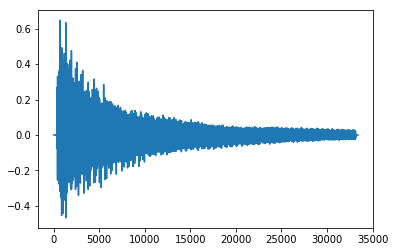

In [76]:
plt.plot(wave.y)

In [77]:
def to_spectral(x, samples):
    xf = np.zeros((x.shape[0] // samples, samples))
    for i in range(0, x.shape[0] - samples, samples):
        w = abs(np.fft.fft(x[i:i+samples], n=samples*2))
        freqs = np.fft.fftfreq(len(w))
        xf[i//samples, :] = w[freqs >= 0]
    return xf

In [78]:
xf = to_spectral(wave.y[:4000], 100)

In [79]:
xf.shape

(40, 100)

In [80]:
xf = xf.reshape(1, 40, 100)

In [81]:
pred = model.predict(xf)

In [82]:
np.argmax(pred[0], axis=1)

array([25,  0,  0,  4, 25, 25], dtype=int64)